In [31]:
import os
import json
import numpy as np
import cv2 as cv  # OpenCV for image processing
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision
from PIL import Image

In [2]:
def load_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
        train_id = data["Image IDs"]["Train Image IDs"]
        test_id = data["Image IDs"]["Test Image IDs"]
        label_map=data["Class Color Codes"]
        return train_id,test_id,label_map
    
path_json_config = '/Users/acer/Downloads/Deep learning in cv/Exercise 3/data/data-config.json'
train_ids,test_ids,color_map= load_json(path_json_config)

In [3]:
color_map

{'0': [255, 255, 255],
 '1': [0, 0, 255],
 '2': [0, 255, 255],
 '3': [0, 255, 0],
 '4': [255, 255, 0],
 '5': [255, 0, 0]}

In [4]:
def map_color2label(color_img,color_code):
    lbl = np.zeros((color_img.shape[0],color_img.shape[1]),dtype=np.uint8)
    for label,color in color_code.items():
        mask = np.all(color_img==np.array(color),axis=-1)
        lbl[mask]=label

    return lbl


In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir, split,cmap, transform=None,label_transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.root_dir, 'images')
        self.label_dir = os.path.join(self.root_dir, 'labels')
        self.cmap = cmap
        self.transform = transform
        self.label_transform = label_transform

        # List of all image files
        self.image_files = sorted(os.listdir(self.image_dir))
        self.label_files = sorted(os.listdir(self.label_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image and label file paths
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        # Read the image and label
        image = cv.imread(img_path, cv.IMREAD_COLOR)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        image  = Image.fromarray(image)
        label = cv.imread(label_path,cv.IMREAD_COLOR)
        label = cv.cvtColor(label, cv.COLOR_BGR2RGB)
        
        # map colors to label in label images
        label = map_color2label(label,self.cmap)
        label = Image.fromarray(label)

        # # Convert image and label to float32
        # image = image.astype(np.float32) / 255.0
        # label = label.astype(np.float32) / 255.0

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)

            # label = self.transform(label)

        return image, label

In [6]:
class ToTensorWithoutScaling:
    def __call__(self, img):
        tensor =  torch.from_numpy(np.array(img)).long()
        return tensor.unsqueeze(0)

In [7]:
root = "/Users/acer/Downloads/Deep learning in cv/Exercise 3/data/256_patch"
trans = transforms.ToTensor()
lbl_trans = ToTensorWithoutScaling()
training_dataset = SegmentationDataset(root_dir=root,split='train',cmap=color_map,transform=trans,label_transform=lbl_trans)
test_datasets = SegmentationDataset(root_dir=root,split='test',cmap=color_map,transform=trans,label_transform=lbl_trans)

In [8]:
training_dataloader = DataLoader(training_dataset,batch_size=8,shuffle=True)
test_dataloader = DataLoader(test_datasets,batch_size=8,shuffle=True)



In [9]:
batch = next(iter(training_dataloader))
images, labels = batch
labels[0]


tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0],
         [3, 3, 3,  ..., 0, 0, 0]]])

In [10]:
# def show_images(loader):
#     batch = next(iter(loader))
#     images, labels = batch
    
#     grid = torchvision.utils.make_grid((labels*50), nrow = 8)
#     plt.figure(figsize=(11,11))
#     plt.imshow(np.transpose(grid,(1,2,0)))
#     # print('labels: ', labels)


In [10]:
def show_images(loader):
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid((images), nrow = 8, padding = 2)
    label_grid = torchvision.utils.make_grid(labels*50, nrow=8, padding=2)
    
    # Plotting the images and labels
    fig, axs = plt.subplots(2, 1, figsize=(15, 6))  # Create 2 rows, 1 column of subplots
    
    # Plot the image grid
    axs[0].imshow(np.transpose(grid.numpy(), (1, 2, 0)))  # Convert from CxHxW to HxWxC
    axs[0].set_title('Training Images')
    axs[0].axis('off')
    
    # Plot the label grid
    axs[1].imshow(np.transpose(label_grid.numpy(), (1, 2, 0)))  # Convert from CxHxW to HxWxC
    axs[1].set_title('Label Images')
    axs[1].axis('off')
    
    plt.show()

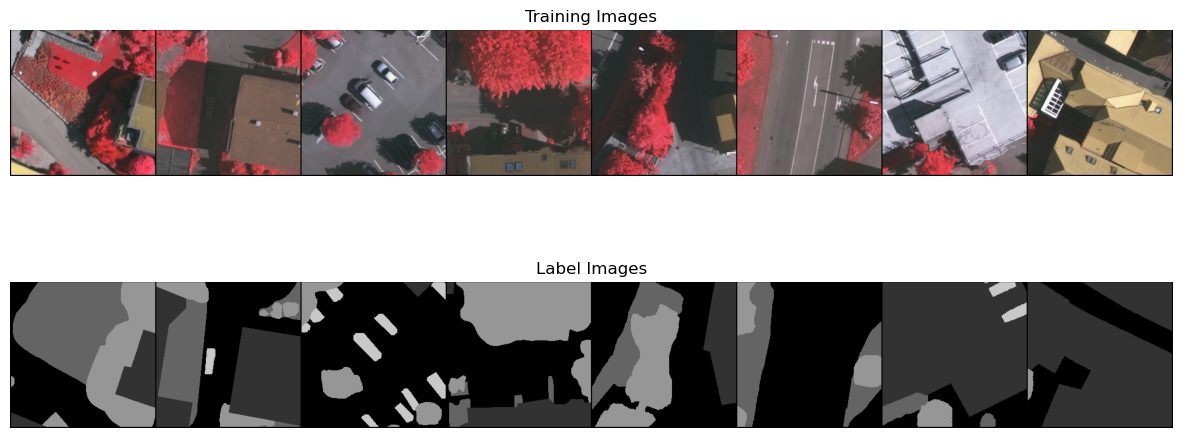

In [11]:
show_images(training_dataloader)

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(64)
#         self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.batch_norm3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.batch_norm4 = nn.BatchNorm2d(128)
#         self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.batch_norm5 = nn.BatchNorm2d(256)
#         self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
#         self.batch_norm6 = nn.BatchNorm2d(256)
#         self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#     def forward(self, x):
#         x = torch.relu(self.batch_norm1(self.conv1(x)))
#         x = torch.relu(self.batch_norm2(self.conv2(x)))
#         x = self.max_pool1(x)

#         x = torch.relu(self.batch_norm3(self.conv3(x)))
#         x = torch.relu(self.batch_norm4(self.conv4(x)))
#         x = self.max_pool2(x)

#         x = torch.relu(self.batch_norm5(self.conv5(x)))
#         x = torch.relu(self.batch_norm6(self.conv6(x)))
#         x = self.max_pool3(x)

#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
#         self.batch_norm7 = nn.BatchNorm2d(128)

#         self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.batch_norm8 = nn.BatchNorm2d(64)

#         self.upsample3 = nn.ConvTranspose2d(64, 6, kernel_size=2, stride=2)
#         self.conv9 = nn.Conv2d(6, 6, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = torch.relu(self.batch_norm7(self.conv7(self.upsample1(x))))
#         x = torch.relu(self.batch_norm8(self.conv8(self.upsample2(x))))
#         x = self.conv9(self.upsample3(x))

#         return x

# class SegNet(nn.Module):
#     def __init__(self):
#         super(SegNet, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [ ]:
# model = SegNet().to(device)
# print(model)

SegNet(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [14]:
import segmentation_models_pytorch as smp

In [15]:
my_model = '/Users/acer/Downloads/Deep learning in cv/Exercise 3/models/unet_resnet18_3channels_25epochs_patchsize256.pt'
model = torch.load(my_model)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
num_epochs = 15

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    model.train()  # Set the model to training mode
    epoch_loss = 0.0
    epoch_correct = 0
    total_samples = 0
    
    for batch_idx, (images, labels) in enumerate(training_dataloader):
        images =images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(images)
      
        outputs = outputs.permute(0, 2, 3, 1).contiguous()  # Ensure channel dimension is last
        outputs = outputs.view(-1, outputs.size(3))
        
        labels = labels.view(-1) 
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        epoch_correct += correct
        total_samples += labels.size(0)
    
    # Average epoch loss and accuracy
    avg_loss = epoch_loss / len(training_dataloader)
    accuracy = epoch_correct / total_samples
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/15
--------------------------------------------------
Epoch [1/15], Loss: 0.3512, Accuracy: 0.8935
Epoch 2/15
--------------------------------------------------
Epoch [2/15], Loss: 0.2620, Accuracy: 0.9173
Epoch 3/15
--------------------------------------------------
Epoch [3/15], Loss: 0.2280, Accuracy: 0.9295
Epoch 4/15
--------------------------------------------------
Epoch [4/15], Loss: 0.2300, Accuracy: 0.9311
Epoch 5/15
--------------------------------------------------
Epoch [5/15], Loss: 0.2175, Accuracy: 0.9336
Epoch 6/15
--------------------------------------------------
Epoch [6/15], Loss: 0.2097, Accuracy: 0.9392
Epoch 7/15
--------------------------------------------------
Epoch [7/15], Loss: 0.2214, Accuracy: 0.9339
Epoch 8/15
--------------------------------------------------
Epoch [8/15], Loss: 0.1845, Accuracy: 0.9414
Epoch 9/15
--------------------------------------------------
Epoch [9/15], Loss: 0.1840, Accuracy: 0.9441
Epoch 10/15
-------------------------

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Set the model to evaluation mode
model.eval()
# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    all_predicted_labels = []
    all_true_labels = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels by finding the class with the max score
        predicted = torch.argmax(outputs, dim=1)
        
        # Flatten the predicted and true labels
        predicted = predicted.view(-1).cpu().numpy()
        labels = labels.view(-1).cpu().numpy()
        
        # Update predicted labels and true labels
        all_predicted_labels.extend(predicted)
        all_true_labels.extend(labels)

# Convert to numpy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_true_labels = np.array(all_true_labels)

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(all_true_labels, all_predicted_labels, zero_division=1)
confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels)

# Print the results
print("Classification Report:")
print(classification_rep)
print()
print("Confusion Matrix:")
print(confusion_mat)
'''
# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Print the results
print("Classification Report:")
print(classification_rep)
print()
print("Confusion Matrix:")
print(confusion_mat)
'''


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86   5471749
           1       0.91      0.91      0.91   5280548
           2       0.73      0.70      0.71   4744446
           3       0.81      0.86      0.83   5531029
           4       0.84      0.65      0.73    255839
           5       0.00      0.00      1.00     15589

    accuracy                           0.83  21299200
   macro avg       0.69      0.66      0.84  21299200
weighted avg       0.83      0.83      0.83  21299200


Confusion Matrix:
[[4646514  250278  383562  164234   25351    1810]
 [ 272896 4805851  144961   50784    2790    3266]
 [ 316812  183176 3316435  925206    1856     961]
 [  80729   27358  688976 4733658     305       3]
 [  72558    8518    3453    4541  165355    1414]
 [   4357    8638    1637     378     579       0]]


'\n# Disable gradient calculations\nwith torch.no_grad():\n    # Initialize variables for predictions and true labels\n    predicted_labels = []\n    true_labels = []\n\n    for images, labels in test_dataloader:\n        images = images.to(device)\n        labels = labels.to(device)\n        \n        # Forward pass\n        outputs = model(images)\n        \n        # Calculate predicted labels\n        _, predicted = torch.max(outputs.data, 1)\n        \n        # Update predicted labels and true labels\n        predicted_labels.extend(predicted.tolist())\n        true_labels.extend(labels.tolist())\n\n# Calculate precision, recall, F1-score, and overall accuracy\nclassification_rep = classification_report(true_labels, predicted_labels)\nconfusion_mat = confusion_matrix(true_labels, predicted_labels)\n\n# Print the results\nprint("Classification Report:")\nprint(classification_rep)\nprint()\nprint("Confusion Matrix:")\nprint(confusion_mat)\n'

In [ ]:
# # Perform argmax to get the class labels
# predicted_labels = torch.argmax(outputs, dim=1)

# # Since `predicted_labels` has shape (1, 256, 256), remove the batch dimension
# predicted_labels = predicted_labels.squeeze(0).cpu().numpy()

# # Print the unique class labels to ensure it worked correctly
# print("Unique class labels in the predicted output:", np.unique(predicted_labels))

Unique class labels in the predicted output: [0 1 2 3 4 5]


In [28]:
def label2color(label_img, color_code):
    
    # Create an empty RGB image
    color_img = np.zeros((label_img.shape[0], label_img.shape[1], 3), dtype=np.uint8)
    
    for label, color in color_code.items():
        mask = label_img == int(label)  # Create a mask for the current class label
        color_img[mask] = color  # Assign the corresponding RGB color
    
    return color_img

In [42]:
test_img = '/Users/acer/Downloads/Deep learning in cv/Exercise 3/data/256_patch/test/images/area30_patch50.tif'
lbl_img = '/Users/acer/Downloads/Deep learning in cv/Exercise 3/data/256_patch/test/labels/area30_patch50.tif'
def segmentation(src,lbl):
    images = cv.cvtColor((cv.imread(src,cv.IMREAD_COLOR)),cv.COLOR_BGR2RGB)
    label = cv.cvtColor((cv.imread(lbl,cv.IMREAD_COLOR)),cv.COLOR_BGR2RGB)
    img = Image.fromarray(images)
    label = Image.fromarray(label)
    preprocess = transforms.Compose([ transforms.ToTensor()])
    img = preprocess(img)
    
    
    input_tensor = img.unsqueeze(0).to(device) 
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _,predict = torch.max(output.data, 1)

    predict = predict.squeeze().cpu().numpy()
    predict = label2color(predict,color_map)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(images)
    axes[1].imshow(predict)
    axes[2].imshow(label)
    plt.show()



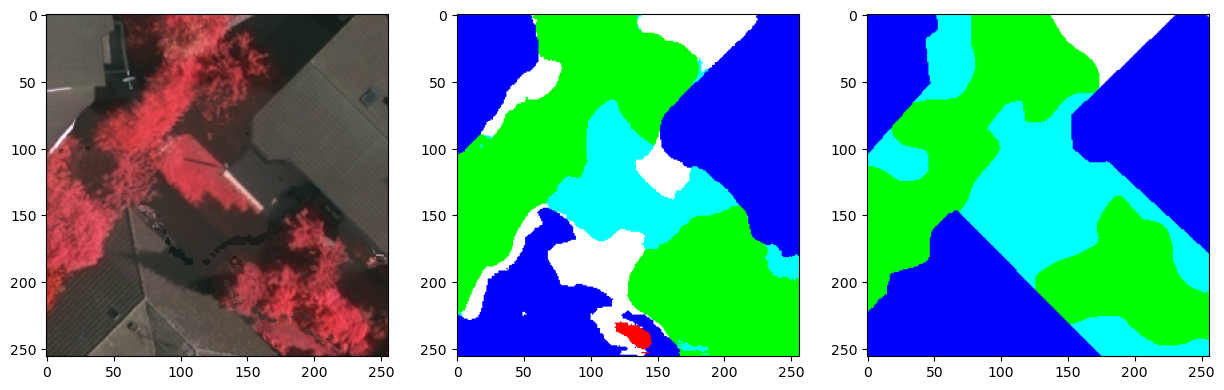

In [43]:
segmentation(test_img,lbl_img)